# Calling the Tree Implementation

In [200]:
import numpy as np
from math import isnan
import threading as trd
import math
import random as rnd
import copy
    

from DensityTree import RandomDensityTree

# The "Density Tree"
Unlike the more commonly used classification or regression trees, decision forest use clustering trees which use a measure of "closeness" or "compactness" to calculate information gain. The split, which is determined by maximizing information gain, like all decision trees, determines in this specific case how the data is divided into clusters. The tee prefers compact clusters of high denity and tends to split the data in areas of low density. <br><br>
The result of the density estimation of the clustering tree is similar to the result of a gaussian mixture model. The tree assumes more or less normally distributed data in each cluster. To estimate the ellipsoid corresponding to the gaussians at each cluster, one simply needs to compute the mean and covariance matrices of the data contained in each leaf node. The main difference to the gaussian mixture model is the fact that the separation lines reprsent hard cut-off lines for the gaussian estimations. Due to this, the results have to be normalized by a partition function. This partition function will be discussed in detail in another notebook.

## This Implementation

Our first idea was to use and modify the already existing sklearn implementation of Decision Trees. This however proved it to be more difficult than expected at first glance,especialy with the specifications needed for our model. Additionally, another group had alreay been working on on a clustering tree, meaning that a significant part of our work had to either be copied or repeated. We therefore decided to first of all focus on implementing our own version of a clustering tree. This implementation only uses plain 'vanilla' python along with several of its most commonly packages, in contrast to the sklearn implementation. The sklearn implementation, written partially in cython allows for much better multithreading.  Overall, this implementation is naturally slower and in many ways less versatile than the sklearn imprementation. Writing our own also also allowed us to implement some interesting features for better visualization of the internal clustering processes. This includes "histories" that keep track of all the splits in the tree as well as functions that immediately allow the retrieval of means and data covariances per leaf. Additionally, this implementatiom allows us to perform non-axis aligned linear splits which were not mentioned in the original paper.<br><br>
The tree consists of a number of node-objects, which, in the case of internal nodes contain references to each of their two child nodes. During training, the node gerentates a number of splits whose values are randomly generated numbers that are bigger than the minimum and smaller than the maximum value of the training data. It then decides on the best one via information_gain. If the information gain does not exceed a ceratin value, the number of data points in either leaf is too small or the maximum depth of the tree has been reached, the tree will not be split. The minimum information gain and maximum depth can be changed by setting them as parameters, but the minimum number of leafs alwas stays the same, due to the fact that the information gain cannot correctly be computed for very small amounts of data. Otherwise, each node will divide the data, then create two child nodes and train them on the divided data sets. This occurs in a recursive manner. <br><br>
For ease of repeated access to each node, a reference to each node is also kept in the 'tree' array at the position 'pointer'. This pointer int-value is usually what is retured in functions asking for a specific node or a number of nodes. Each node also contains a list of previous splits leading up to that node. The split value is recorded, as well with the direction of the split along with the fact whether we this node is in the right or the left child of the split. For non-axis aligned splits, the data is recorded as a starting point and a directional vector. this implementation can only handle 2-dimensional data but could be easily adapted for more-dimensional data.

# Visualization

In [191]:
from matplotlib.patches import Ellipse

#this plots the lines of the splits
def plotsplits(h,s,hor=[0,6],vert=[0,6]):
   
        plotsplits(h,s+1,hor,vert) 

#fuction that plots the data with axis-aligned splits and gaussian estimations
def plotaxis(data,DensityTree,xlim=[0,6],ylim=[0,6],title='test',showcov=True):
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])

    nodes=DensityTree.leaf_nodes()
    tree=DensityTree.tree
    ax.plot(data[:,0],data[:,1], "o")
    
    
    for d in nodes:
        #these limit not only the entire plot but also the seperating lines
        vert=xlim
        hor=ylim
        
        #the splits are reconstructed from the history
        #for each step in the history
        for h in tree[d].history:
            
            #choose the correction on which to split
            if h['direction']==0:
                ax.plot([h['split'],h['split']],vert,color='k')
              
                #new limitations of the split-lines are set here
                if(h['child']=='left'):
                    hor=[hor[0],h['split']]
                else:
                    hor=[h['split'],hor[1]]
        
            else:
                ax.plot(hor,[h['split'],h['split']],color='k')
                
                if(h['child']=='left'):
                    vert=[vert[0],h['split']]
                else:
                    vert=[h['split'],vert[1]]
        #show the ellipses corresponding to gaussians only when this is true
        if(showcov==True):
            
            #use eigenvalues and eigenvectors for visualization
            eigvals,eigvecs=np.linalg.eig(tree[d].cov)
           
            
            #determine the largest eigenvalues
            if(eigvals[0]>eigvals[1]):
                use_vec=eigvecs[1]
                height=math.sqrt(eigvals[1]*5.991)*2
                width=math.sqrt(eigvals[0]*5.991)*2
            else:
                use_vec=eigvecs[0]
                height=math.sqrt(eigvals[0]*5.991)*2
                width=math.sqrt(eigvals[1]*5.991)*2  
            
            #compute the angle of the eigenvector with the largest eigenvector
            angle=(180/math.pi)*np.arctan(use_vec[0]/use_vec[1])

            #make ellipses, depth and height are determined by the eigenvalues
            e=Ellipse(xy=tree[d].mean, width=width, height=height, angle=angle,alpha=0.5,edgecolor='none')
            ax.add_artist(e)

            plt.plot(tree[d].mean[0],tree[d].mean[1],'o',color='r')

    plt.show()
    

   # plt.savefig('results')
    
def plotlin(data,DensityTree,xlim=[0,6],ylim=[0,6],title='test',showlines=True,showcov=True):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xlim(xlim[0],xlim[1])

    nodes=DensityTree.leaf_nodes()
    tree=DensityTree.tree
    ax.plot(data[:,0],data[:,1], "o")
    for d in nodes:
        if(showlines==True):
            #visualization only draws directional lines and origin points but they are not limited
            for h in tree[d].history:
                ax.plot([(h['split']+h['direction']*10)[0],(h['split']+h['direction']*-10)[0]],[(h['split']+h['direction']*10)[1],(h['split']+h['direction']*-10)[1]],color='k')
                ax.plot(h['split'][0],h['split'][1],"s",color='g')

        if(showcov==True):
            eigvals,eigvecs=np.linalg.eig(tree[d].cov)
           
           
            if(eigvals[0]>eigvals[1]):
                use_vec=eigvecs[1]
                height=math.sqrt(eigvals[1]*5.991)*2
                width=math.sqrt(eigvals[0]*5.991)*2
            else:
                use_vec=eigvecs[0]
                height=math.sqrt(eigvals[0]*5.991)*2
                width=math.sqrt(eigvals[1]*5.991)*2  
            angle=(180/math.pi)*np.arctan(use_vec[0]/use_vec[1])              #np.dot(use_vec,vec1)/(np.linalg.norm(vec1)*np.linalg.norm(use_vec)))

            e=Ellipse(xy=tree[d].mean, width=width, height=height, angle=angle,alpha=0.5,edgecolor='none')
            ax.add_artist(e)

            plt.plot(tree[d].mean[0],tree[d].mean[1],'o',color='r')
    plt.show()
#plotaxis(data,DensityTree,xlim=[0,6],ylim=[0,6])

# Simple Data Example
The following data will be used for a number of clustering tests. It contains 4 loosely seperated groups of data points. The idead ideal axis-aligned separation of th data would e achived by a tree of depth two, and the splits would be placed at areas of low density, resulting the seperation lines following a loose "plus"-shape. 

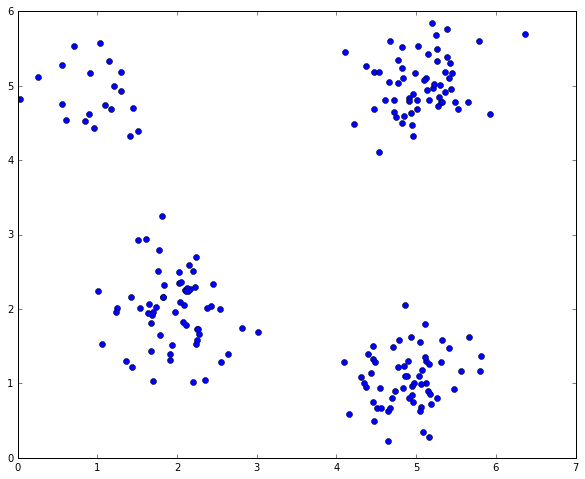

In [141]:
%matplotlib inline
import matplotlib.pyplot as plt

data = np.zeros([200,2])
for i in range(60):
    data[i]=np.random.normal([2,2],0.4)

for i in range(60):
    data[60+i]=np.random.normal([5,5],0.4)

for i in range(60):
    data[120+i]=np.random.normal([5,1],0.4)
   
for i in range(20):
    data[180+i]=np.random.normal([1,5],0.4)
plt.figure(figsize=(10,8))
plt.plot(data[:,0],data[:,1], "o")

plt.show()

# The "Perfect" Fit

The folowing image shows the actual splits computed by a Clustering Tree with depth 2. The seperating lines follow the expected pattern of two splits, which are placed at areas of low density. The second image shows the resulting means of the clusters as red dots and and a representation of the ellipsis corresponding to gaussian. The ellipsis is a representation of the 95% confidence area ans was craeted by using the covariance matrix. The length and width of the ellipsis are given as two times the square root of the eigenvalues of the covariance matrix multiplied by 5.991.

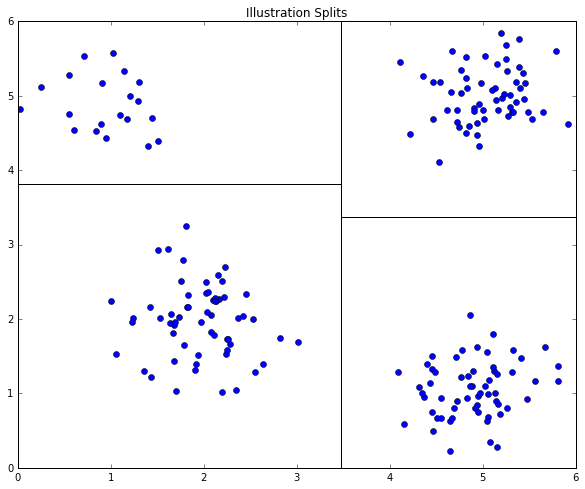

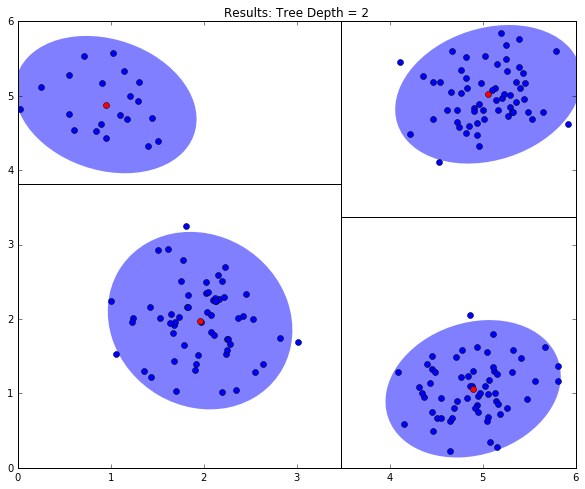

In [201]:
DensityTree1=RandomDensityTree(max_depth=2,min_infogain=0.2,num_splits=50)
DensityTree1.fit(data)

plotaxis(data,DensityTree1,xlim=[0,6],ylim=[0,6],showcov=False,title='Illustration Splits')
plotaxis(data,DensityTree1,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 2')

#DensityTree2=RandomDensityTree(max_depth=2,splittype='linear',min_infogain=0.2,num_splits=400)
#DensityTree2.fit(data)

# Underfitting 
The following images shows the effect of choosing too shallow or too deep trees for clustering. In the first image shows how clustering was achieved by a tree of depth 1. This very noticably underfits the data. This also shows quite nicely, that even if the splits are axis aligned this is not necessarily true for the computed Gaussianfunctions. 

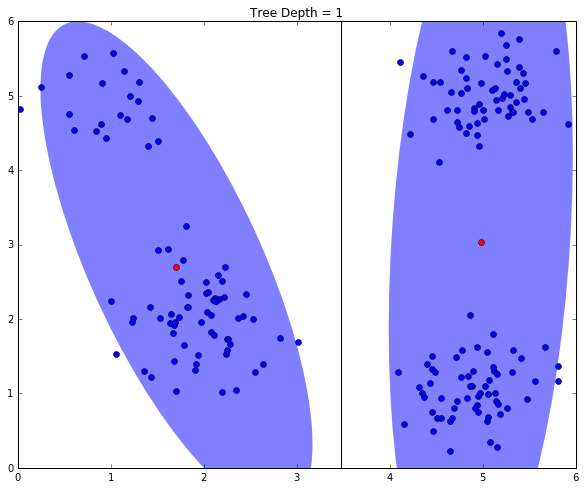

In [157]:
DensityTree2=RandomDensityTree(max_depth=1,min_infogain=0.2,num_splits=50)
DensityTree2.fit(data)
plotaxis(data,DensityTree2,xlim=[0,6],ylim=[0,6],title='Tree Depth = 1')


# Overfitting
This image below shows a tree of depth 4 being being used to cluster the data. As is plainly visible, this tree noticably overfits the data. Both of these images show the importance of choosing the right parameter values like tree depth, at least when only a a single tree is used. In a forest where several trees are used and averaged, slight overfitting for a single tree is less problematic.

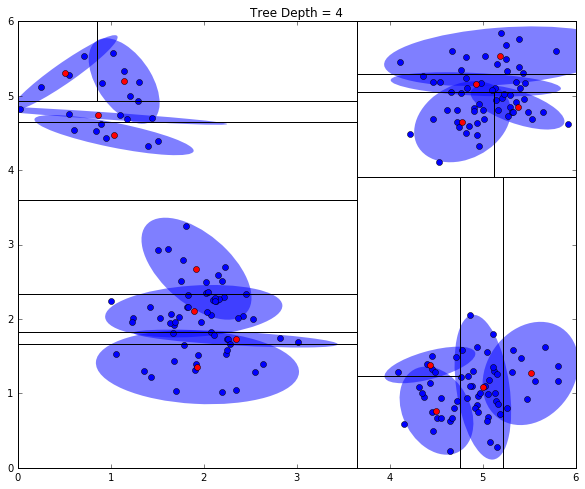

In [158]:
DensityTree3=RandomDensityTree(max_depth=4,min_infogain=0.001,num_splits=50)
DensityTree3.fit(data)
plotaxis(data,DensityTree3,xlim=[0,6],ylim=[0,6],title='Tree Depth = 4')




Instead of a fixed-depth tree, branches of varying depth are also possible. In the following 2 images, minimum information-gain is a more important criterium for splitting than maximum depth. With this specific minimum information gain chosen, we can end up with a slightly overfitted tree. The image below those two show how a perfect split can be achieved by choosing a specific information gain. Having knowledge of the task, data and context can therefore be very important, a similar truth holds for choosing the right depth.

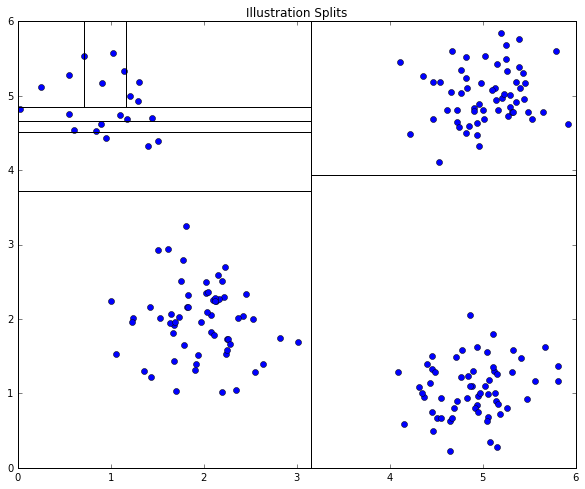

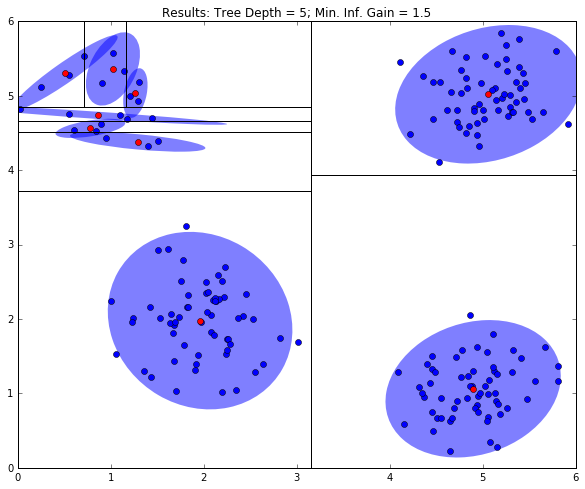

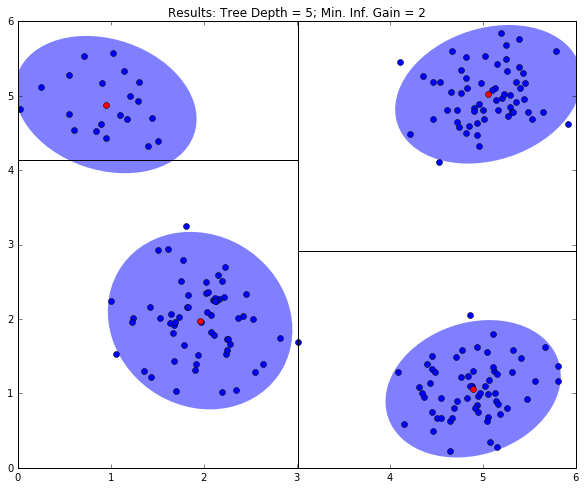

In [159]:
DensityTreeEx=RandomDensityTree(max_depth=5,min_infogain=1.5,num_splits=50)
DensityTreeEx.fit(data)
DensityTreeEx2=RandomDensityTree(max_depth=5,min_infogain=2,num_splits=50)
DensityTreeEx2.fit(data)

plotaxis(data,DensityTreeEx,xlim=[0,6],ylim=[0,6],showcov=False,title='Illustration Splits')
plotaxis(data,DensityTreeEx,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 5; Min. Inf. Gain = 1.5')
plotaxis(data,DensityTreeEx2,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 5; Min. Inf. Gain = 2')

# Linear Separation
This image shows the effect of results of performing non-axis aligned linear separation while clustering. Our implementation uses random splits for linear separation as well, with origin points and directional vectors being randonly chosen. The first image shows the seperatrices as black lines and the origin points of the separating vectors as clusters. The vectors in this visualization go all the way through, which is not an accurate representation of the actual clustering. Like with all decision trees, splits only affect. The origin points and resulting ellipses allow us to reconstruct the vectors how they actually are. <br><br>
Also note that for this particular probem, many very differentdifferent non-linear separations exist. Using axis aligned splits is not actually better or more useful than using axis aligned splits in this case, this is quite possibly true for many other problems. The effectivity is also limited by the randomness of the gerenerated splits.

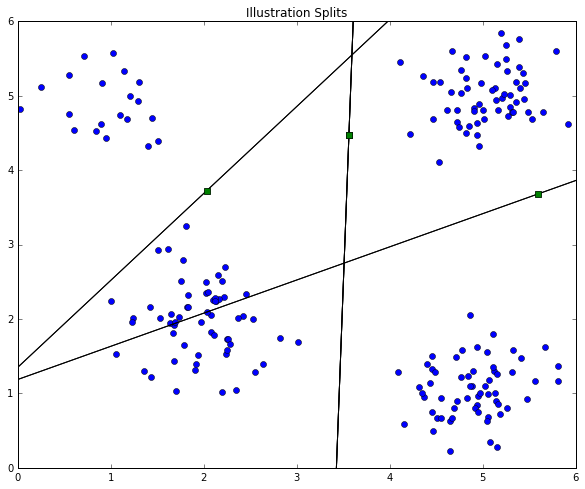

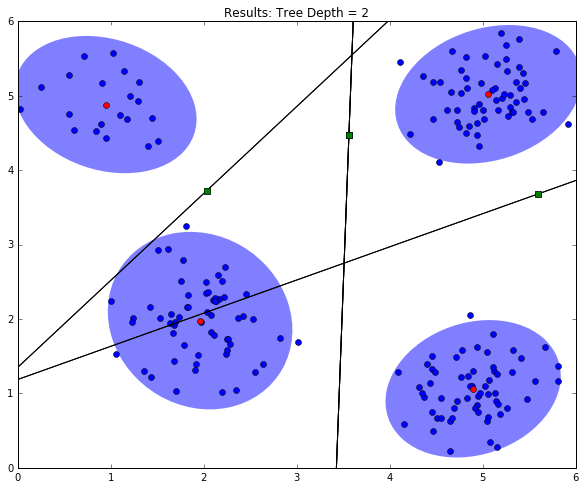

In [168]:
DensityTree5=RandomDensityTree(max_depth=2,min_infogain=0.2,num_splits=50,splittype='linear')
DensityTree5.fit(data)

plotlin(data,DensityTree5,xlim=[0,6],ylim=[0,6],showcov=False,title='Illustration Splits')
plotlin(data,DensityTree5,xlim=[0,6],ylim=[0,6],title='Results: Tree Depth = 2')

This is a reconstruction example of how the splits may actually look like, based on the previous visualizations. Green lines represent the read splits while the dotted lines are the the parts of the splits that do not actually exist.

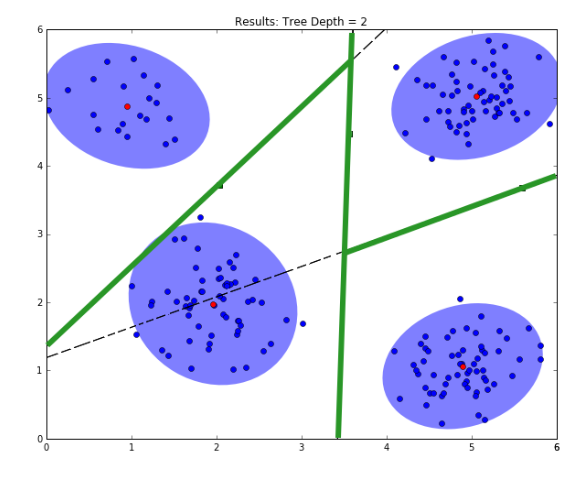

In [185]:
import matplotlib.image as mpimg
fig = plt.figure(figsize=(10,8),frameon=False)
img=mpimg.imread('realsplits.png')
plt.axis('off')
imgplot = plt.imshow(img)


# Other Visualizations

The following images show visualizations of splits for example data that we used to test the whole trees. Some of the examples are cherry picked to show the best results. However, for many other exmples no high quality results were possible if only a single tree was used.

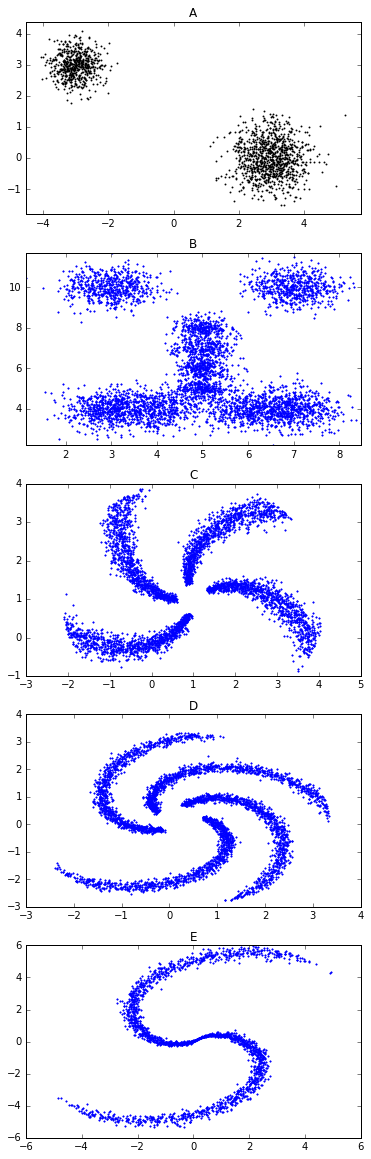

In [25]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture


plt.figure(figsize=(6, 20))
#plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)


n_samples1 = 600
n_samples2 = 1000
# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
gaussian1 = 0.4*np.random.randn(n_samples1,2) + np.array([-3, 3])
gaussian2 = 0.6*np.random.randn(n_samples2,2) + np.array([3, 0])

X_train = np.vstack([gaussian1, gaussian2])


plt.subplot(511)
plt.scatter(X_train[:, 0], X_train[:, 1], .8)
plt.title('A')
plt.axis('tight')


obs = np.concatenate((np.array([3, 10])+0.5*np.random.randn(600, 2),
      np.array([7, 10])+ 0.5*np.random.randn(600, 2),
      np.array([5, 8]) + 0.3*np.random.randn(300, 2),
      np.array([5, 7]) + 0.3*np.random.randn(300, 2),
      np.array([5, 6])+ 0.3*np.random.randn(300, 2),
      np.array([5, 5])+ 0.3*np.random.randn(300, 2), 
      np.array([3, 4]) + 0.5*np.random.randn(600, 2),
      np.array([4, 4]) + 0.5*np.random.randn(500, 2),
      np.array([6, 4]) + 0.5*np.random.randn(500, 2),
      np.array([7, 4]) + 0.5*np.random.randn(600, 2)))
   


plt.subplot(512)
plt.plot(obs[:, 0], obs[:, 1], '.', markersize=3)
plt.title('B')
plt.axis('tight')





N3 = 1000 # number of points per class
D3 = 2 # dimensionality
K3 = 4 # number of classes
X3 = np.zeros((N3*K3,D3)) # data matrix (each row = single example)
y3 = np.zeros(N3*K3, dtype='uint8') # class labels
for j in range(K3):
  ix = range(N3*j,N3*(j+1))
  #r = np.linspace(0.0,1,N) # radius
  r = np.linspace(0.4, 1*np.pi, N3, endpoint=False)
  t = np.linspace((j+0.2)*5,(j+0.4)*5,N3) + np.random.randn(N3)*0.1 # theta
  X3[ix] = np.c_[r*np.sin(t)+1, r*np.cos(t)+1]
  y3[ix] = j
# lets visualize the data:
plt.subplot(513)
plt.plot(X3[:, 0], X3[:, 1], '.', markersize=3)
plt.title('C')


N4 = 1000 # number of points per class
D4 = 2 # dimensionality
K4 = 4 # number of classes
X4 = np.zeros((N4*K4,D4)) # data matrix (each row = single example)
y4 = np.zeros(N4*K4, dtype='uint8') # class labels
for j in range(K4):
  ix = range(N4*j,N4*(j+1))
  #r = np.linspace(0.0,1,N) # radius
  r = np.linspace(0.5, 1*np.pi, N4, endpoint=False)
  t = np.linspace((j+0.3)*5,(j+0.8)*5,N4) + np.random.randn(N4)*0.1 # theta
  X4[ix] = np.c_[r*np.sin(t)+0.2, r*np.cos(t)+0.2]
  y4[ix] = j
# lets visualize the data:
plt.subplot(514)
plt.plot(X4[:, 0], X4[:, 1], '.', markersize=3)
plt.title('D')





N5 = 1000 # number of points per class
D5 = 2 # dimensionality
K5 = 2 # number of classes
X5 = np.zeros((N5*K5,D5)) # data matrix (each row = single example)
y5 = np.zeros(N5*K5, dtype='uint8') # class labels
for j in range(K5):
  ix = range(N5*j,N5*(j+1))
  #r = np.linspace(0.0,1,N) # radius
  r = np.linspace(0, 2*np.pi, N5, endpoint=False)
  t = np.linspace((j+0.3)*3,(j+1.3)*3,N5) + np.random.randn(N5)*0.1 # theta
  X5[ix] = np.c_[r*np.sin(t)+0.2, r*np.cos(t)+0.2]
  y5[ix] = j
# lets visualize the data:
plt.subplot(515)
plt.plot(X5[:, 0], X5[:, 1], '.', markersize=3)
plt.title('E')






plt.show()




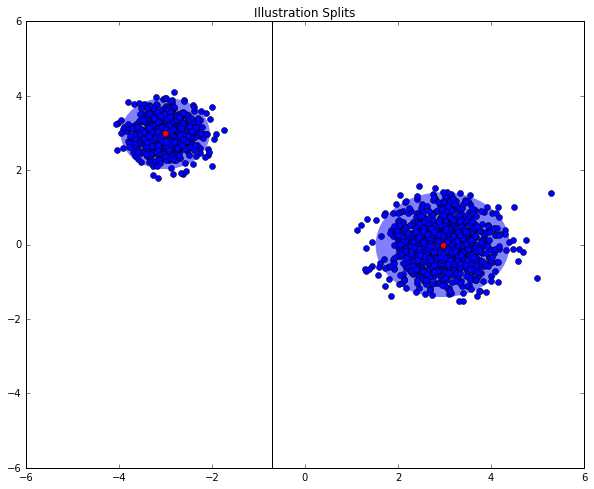

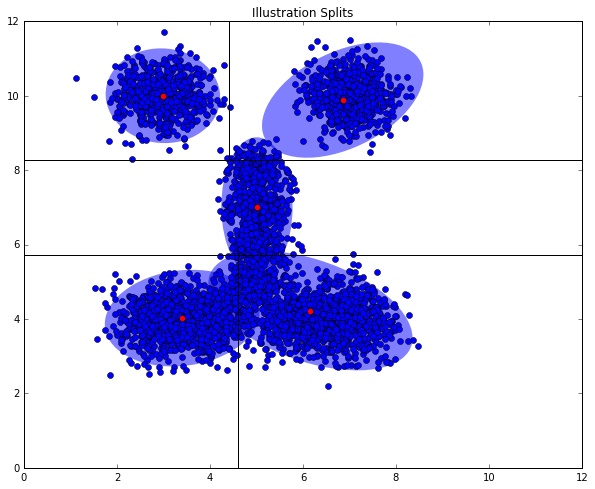

In [160]:
DensityTree7=RandomDensityTree(max_depth=5,min_infogain=1.5,num_splits=50,splittype='axis')
DensityTree7.fit(X_train)

plotaxis(X_train,DensityTree7,xlim=[-6,6],ylim=[-6,6],showcov=True,title='Illustration Splits')

DensityTree8=RandomDensityTree(max_depth=5,min_infogain=1.5,num_splits=50,splittype='axis')
DensityTree8.fit(obs)

plotaxis(obs,DensityTree8,xlim=[0,12],ylim=[0,12],showcov=True,title='Illustration Splits')

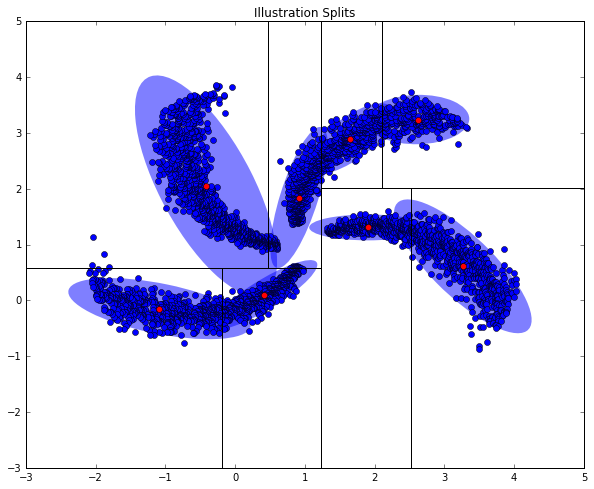

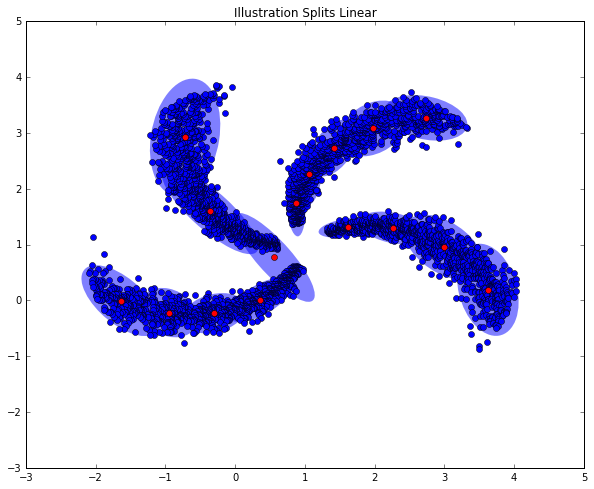

In [196]:
DensityTree9=RandomDensityTree(max_depth=3,min_infogain=0.05,num_splits=50,splittype='axis')
DensityTree9.fit(X3)
plotaxis(X3,DensityTree9,xlim=[-3,5],ylim=[-3,5],showcov=True,title='Illustration Splits')
DensityTree9lin=RandomDensityTree(max_depth=4,min_infogain=0.05,num_splits=50,splittype='linear')
DensityTree9lin.fit(X3)
plotlin(X3,DensityTree9lin,xlim=[-3,5],ylim=[-3,5],showlines=False,showcov=True,title='Illustration Splits Linear')

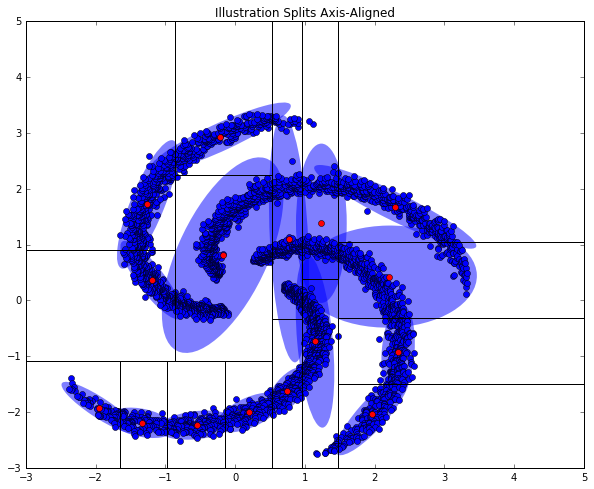

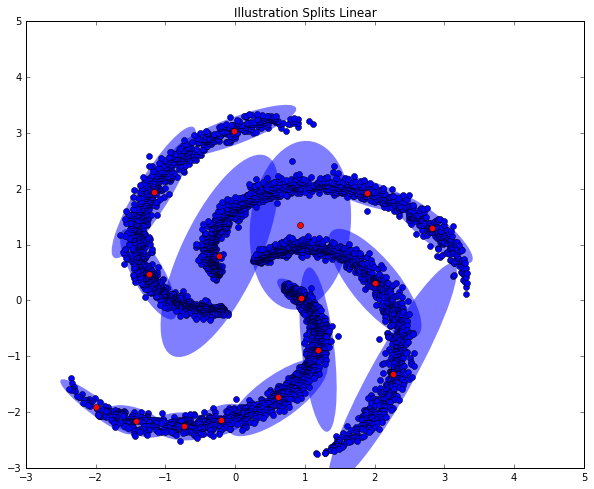

In [194]:
DensityTree10=RandomDensityTree(max_depth=4,min_infogain=0.05,num_splits=50,splittype='axis')
DensityTree10.fit(X4)
plotaxis(X4,DensityTree10,xlim=[-3,5],ylim=[-3,5],showcov=True,title='Illustration Splits Axis-Aligned')
DensityTree10lin=RandomDensityTree(max_depth=4,min_infogain=0.05,num_splits=50,splittype='linear')
DensityTree10lin.fit(X4)
plotlin(X4,DensityTree10lin,xlim=[-3,5],ylim=[-3,5],showlines=False,showcov=True,title='Illustration Splits Linear')

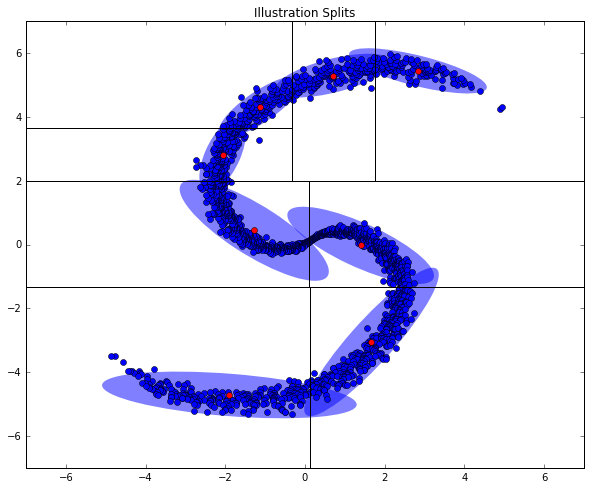

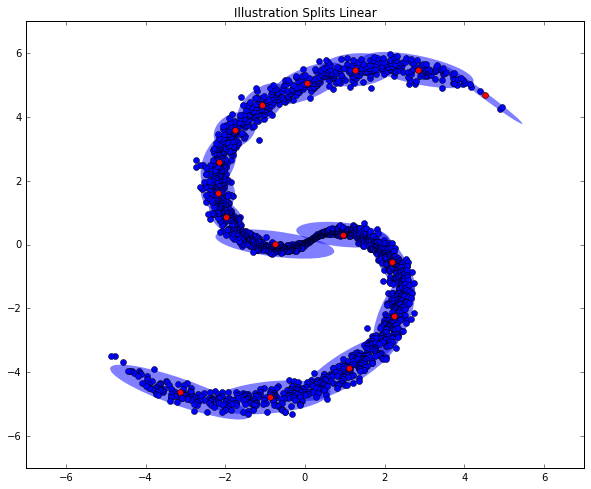

In [198]:
DensityTree11=RandomDensityTree(max_depth=3,min_infogain=0.05,num_splits=50,splittype='axis')
DensityTree11.fit(X5)
plotaxis(X5,DensityTree11,xlim=[-7,7],ylim=[-7,7],showcov=True,title='Illustration Splits')
DensityTree11lin=RandomDensityTree(max_depth=4,min_infogain=0.05,num_splits=50,splittype='linear')
DensityTree11lin.fit(X5)
plotlin(X5,DensityTree11lin,xlim=[-7,7],ylim=[-7,7],showlines=False,showcov=True,title='Illustration Splits Linear')